In [ ]:
!pwd

/content/ASNet


In [ ]:
import os
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

import time
import sys

# from ASNet.active_subspace import *
from datasets.dataloader_cifar import *
from ASNet.utils import *
from ASNet.PCEModel import *
from ASNet.ASModel import *
from ASNet.FineTuning import *
from ASNet.ASNet import *
from model.resnet import *# resnet20,resnet32,resnet44,resnet56,resnet110#1202
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# torch.cuda.set_device(0)
# CUDA_VISIBLE_DEVICES=0

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device = torch.device('cpu')


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# Load the dataset
bs = 200
train_loader = trainloader_resnet(bs)
test_loader = testloader_resnet(bs)
test_labels = torch.tensor(test_loader.dataset.targets)
train_labels = torch.tensor(train_loader.dataset.targets)

Files already downloaded and verified


In [ ]:
modelname = 'resnet110'
if modelname == 'resnet110':
    model = resnet110()
elif modelname == 'resnet56':    
    model = resnet56()
elif modelname == 'resnet44':
    model = resnet44()
elif modelname == 'resnet20':
    model = resnet20()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
!wget https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet110-1d1ed7c2.th

--2020-12-15 23:24:15--  https://github.com/akamaster/pytorch_resnet_cifar10/raw/master/pretrained_models/resnet110-1d1ed7c2.th
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/master/pretrained_models/resnet110-1d1ed7c2.th [following]
--2020-12-15 23:24:16--  https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/master/pretrained_models/resnet110-1d1ed7c2.th
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7031437 (6.7M) [application/octet-stream]
Saving to: ‘resnet110-1d1ed7c2.th’

resnet110-1d1ed7c2. 100%[===================>]   6.71M  --.-KB/s    in

In [ ]:
#pretrained = 'resnet110-1d1ed7c2.th'.format(modelname)
pretrained = 'resnet110-1d1ed7c2.th'
if torch.cuda.is_available():
    tmp = torch.load(pretrained)
else:
    tmp = torch.load(pretrained, torch.device('cpu'))


model.load_state_dict(tmp['state_dict'], strict=False)

model.to(device)
model.eval()
print(model)
seq_model = get_seq_model_resnet(model)
seq_model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (2): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
train_max_batch = len(train_loader)

######### Training
nAS = 50
r_max = max(200,nAS)
loss = F.cross_entropy
add_softmax = False
p = 2

In [ ]:
seq_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (2): BasicBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
cut_idx =31
cut_idx_seq = cut_idx
pre_model = seq_model[:cut_idx_seq].eval().to(device)
post_model = seq_model[cut_idx_seq:].eval().to(device)


# Load or compute the AS Layer
fAS_name = '%s_CIFAR_10_ASModel_nAS_%d_cutID_%d.pth'%(modelname,nAS,cut_idx)
if os.path.isfile(fAS_name):
    AS_models, Sigma = torch.load(fAS_name)
    print('    AS layer loaded')
else:
    AS_models, Sigma = get_ASModel_FD(seq_model, train_loader,
              cut_idx_seq, train_max_batch,r_max,device)
    torch.save([AS_models,Sigma], fAS_name) 
    print('    AS layer computed')

for key in AS_models.keys():
    AS_model = AS_models[key]
AS_model.change_r(nAS)


Z_train, y_train = compute_Z_AS_space(AS_model, pre_model, post_model, train_loader, 
        train_max_batch,device=device)


print('Z_train, Z_test generated')
mean = torch.mean(Z_train,0).to(device)
var =  torch.std(Z_train,0).to(device)
PCE_model = PCEModel(mean,var,nAS,p, device=device)

Z_train = Z_train.to(device)
y_train = y_train.to(device)
train_labels = train_labels.to(device)
coeff, training_score_LR, training_score_labels = PCE_model.Training(Z_train, y_train,train_labels[:Z_train.shape[0]])
PCE_coeff = torch.tensor(coeff,dtype=torch.float32).to(device)
print('Training score =', training_score_LR, \
      'label score', training_score_labels)


Finished Building AS model for layer: 30
    AS layer computed
Z_train, Z_test generated
Training score = 0.6912216224930826 label score 0.09986


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


https://github.com/akamaster/pytorch_resnet_cifar10

In [ ]:
basis_layer = BasisLayer(PCE_model,device=device)
ASNet = ASNET(pre_model, AS_model, basis_layer,PCE_coeff).to(device)

print('Training and testing error for ASNet without re-training')
optimizer = torch.optim.Adam([{'params': ASNet.premodel.parameters(),'lr': 1e-3},
                            {'params': ASNet.AS.parameters(), 'lr': 1e-5},
                            {'params': ASNet.PCE.parameters(), 'lr': 1e-5}])

epochs = 50   
filename = 'CIFAR10_ResNet110_ASNet'+\
        '_epoch_%d_nAS_%d_cutID_%d.pth'%(epochs,nAS,cut_idx)

if os.path.isfile(filename): 
    [ASNet_pretrained,train_loss,test_loss] = torch.load(filename)
    ASNet.load_state_dict(ASNet_pretrained)
    print('ASNet trained {} epoches is loaded'.format(epochs))
else:
    train_loss = []
    test_loss = []
    train_loss.append(compute_loss(ASNet, device, train_loader))
    test_loss.append(compute_loss(ASNet, device, test_loader))
    
    for epoch in range(1, epochs + 1):
        print('EPOCH {}'.format(epoch))
        print(device)
        train_loss.append(train_kd(ASNet, model, device, train_loader, optimizer, train_max_batch, 
                  alpha=0.2, temperature=1., epoch=epoch))
        test_loss.append(compute_loss(ASNet, device, test_loader))

    torch.save([ASNet.state_dict(),train_loss,test_loss],filename)

Training and testing error for ASNet without re-training
 Top 1:  Accuracy: 39312.0/50000 (78.62%)
 Top 1:  Accuracy: 7966.0/10000 (79.66%)
EPOCH 1
cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


 Top 1:  Accuracy: 8279.0/10000 (82.79%)
EPOCH 2
cuda:0
 Top 1:  Accuracy: 8497.0/10000 (84.97%)
EPOCH 3
cuda:0
 Top 1:  Accuracy: 8604.0/10000 (86.04%)
EPOCH 4
cuda:0
 Top 1:  Accuracy: 8727.0/10000 (87.27%)
EPOCH 5
cuda:0
 Top 1:  Accuracy: 8734.0/10000 (87.34%)
EPOCH 6
cuda:0
 Top 1:  Accuracy: 8769.0/10000 (87.69%)
EPOCH 7
cuda:0
 Top 1:  Accuracy: 8816.0/10000 (88.16%)
EPOCH 8
cuda:0
 Top 1:  Accuracy: 8816.0/10000 (88.16%)
EPOCH 9
cuda:0
 Top 1:  Accuracy: 8847.0/10000 (88.47%)
EPOCH 10
cuda:0
 Top 1:  Accuracy: 8853.0/10000 (88.53%)
EPOCH 11
cuda:0
 Top 1:  Accuracy: 8865.0/10000 (88.65%)
EPOCH 12
cuda:0
 Top 1:  Accuracy: 8885.0/10000 (88.85%)
EPOCH 13
cuda:0
 Top 1:  Accuracy: 8897.0/10000 (88.97%)
EPOCH 14
cuda:0
 Top 1:  Accuracy: 8894.0/10000 (88.94%)
EPOCH 15
cuda:0
 Top 1:  Accuracy: 8899.0/10000 (88.99%)
EPOCH 16
cuda:0
 Top 1:  Accuracy: 8897.0/10000 (88.97%)
EPOCH 17
cuda:0
 Top 1:  Accuracy: 8898.0/10000 (88.98%)
EPOCH 18
cuda:0
 Top 1:  Accuracy: 8915.0/10000 (89.15%

In [ ]:
print(100*(1.0-Total_flops_sparse(ASNet, device)/Total_flops_sparse(model, device)))
print(test_loss[0])
print(test_loss[-1])
print(100*(1.0-Total_param_sparse(ASNet)/Total_param_sparse(model)))

44.14779715642929
tensor(79.6600)
tensor(89.4600)
57.972527932571104


/content/ASNet/ASNet/utils.py:35: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  flops += x.shape[2:].numel()*m.weight.data.nonzero().shape[0]


In [ ]:
compression_rates = []
zero_results = []
tune_results = []
floaps_compression = []
idxes = []
singular_values = []
sigmas = []



for cut_idx in range(4, 50, 4):
  idxes.append(cut_idx)
  cut_idx_seq = cut_idx
  pre_model = seq_model[:cut_idx_seq].eval().to(device)
  post_model = seq_model[cut_idx_seq:].eval().to(device)


  # Load or compute the AS Layer
  fAS_name = '%s_CIFAR_10_ASModel_nAS_%d_cutID_%d.pth'%(modelname,nAS,cut_idx)
  if os.path.isfile(fAS_name):
      AS_models, Sigma = torch.load(fAS_name)
      print('    AS layer loaded')
  else:
      AS_models, Sigma = get_ASModel_FD(seq_model, train_loader,
                cut_idx_seq, train_max_batch,r_max,device)
      torch.save([AS_models,Sigma], fAS_name) 
      print('    AS layer computed')

  for key in AS_models.keys():
      AS_model = AS_models[key]
  AS_model.change_r(nAS)


  Z_train, y_train = compute_Z_AS_space(AS_model, pre_model, post_model, train_loader, 
          train_max_batch,device=device)


  print('Z_train, Z_test generated')
  mean = torch.mean(Z_train,0).to(device)
  var =  torch.std(Z_train,0).to(device)
  PCE_model = PCEModel(mean,var,nAS,p, device=device)

  Z_train = Z_train.to(device)
  y_train = y_train.to(device)
  train_labels = train_labels.to(device)
  coeff, training_score_LR, training_score_labels = PCE_model.Training(Z_train, y_train,train_labels[:Z_train.shape[0]])
  PCE_coeff = torch.tensor(coeff,dtype=torch.float32).to(device)
  print('Training score =', training_score_LR, \
        'label score', training_score_labels)




  basis_layer = BasisLayer(PCE_model,device=device)
  ASNet = ASNET(pre_model, AS_model, basis_layer,PCE_coeff).to(device)

  print('Training and testing error for ASNet without re-training')
  optimizer = torch.optim.Adam([{'params': ASNet.premodel.parameters(),'lr': 1e-3},
                              {'params': ASNet.AS.parameters(), 'lr': 1e-5},
                              {'params': ASNet.PCE.parameters(), 'lr': 1e-5}])

  epochs = 15 
  filename = 'CIFAR10_ResNet110_ASNet'+\
          '_epoch_%d_nAS_%d_cutID_%d.pth'%(epochs,nAS,cut_idx)

  if os.path.isfile(filename): 
      [ASNet_pretrained,train_loss,test_loss] = torch.load(filename)
      ASNet.load_state_dict(ASNet_pretrained)
      print('ASNet trained {} epoches is loaded'.format(epochs))
  else:
      train_loss = []
      test_loss = []
      train_loss.append(compute_loss(ASNet, device, train_loader))
      test_loss.append(compute_loss(ASNet, device, test_loader))
      
      for epoch in range(1, epochs + 1):
          print('EPOCH {}'.format(epoch))
          print(device)
          train_loss.append(train_kd(ASNet, model, device, train_loader, optimizer, train_max_batch, 
                    alpha=0.2, temperature=1., epoch=epoch))
          test_loss.append(compute_loss(ASNet, device, test_loader))

      torch.save([ASNet.state_dict(),train_loss,test_loss],filename)
  compression_rates.append(100*(1.0-Total_param_sparse(ASNet)/Total_param_sparse(model)))
  floaps_compression.append(100*(1.0-Total_flops_sparse(ASNet, device)/Total_flops_sparse(model, device)))
  zero_results.append(test_loss[0])
  tune_results.append(test_loss[-1])
  sigmas.append(Sigma)


    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.8527423842315033 label score 0.09912
Training and testing error for ASNet without re-training
 Top 1:  Accuracy: 46649.0/50000 (93.30%)
 Top 1:  Accuracy: 8930.0/10000 (89.30%)
EPOCH 1
cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


 Top 1:  Accuracy: 8981.0/10000 (89.81%)
EPOCH 2
cuda:0
 Top 1:  Accuracy: 9017.0/10000 (90.17%)
EPOCH 3
cuda:0
 Top 1:  Accuracy: 9191.0/10000 (91.91%)
EPOCH 4
cuda:0
 Top 1:  Accuracy: 9202.0/10000 (92.02%)
EPOCH 5
cuda:0
 Top 1:  Accuracy: 9255.0/10000 (92.55%)
EPOCH 6
cuda:0
 Top 1:  Accuracy: 9236.0/10000 (92.36%)
EPOCH 7
cuda:0
 Top 1:  Accuracy: 9268.0/10000 (92.68%)
EPOCH 8
cuda:0
 Top 1:  Accuracy: 9250.0/10000 (92.50%)
EPOCH 9
cuda:0
 Top 1:  Accuracy: 9257.0/10000 (92.57%)
EPOCH 10
cuda:0
 Top 1:  Accuracy: 9275.0/10000 (92.75%)
EPOCH 11
cuda:0
 Top 1:  Accuracy: 9252.0/10000 (92.52%)
EPOCH 12
cuda:0
 Top 1:  Accuracy: 9267.0/10000 (92.67%)
EPOCH 13
cuda:0
 Top 1:  Accuracy: 9266.0/10000 (92.66%)
EPOCH 14
cuda:0
 Top 1:  Accuracy: 9275.0/10000 (92.75%)
EPOCH 15
cuda:0
 Top 1:  Accuracy: 9270.0/10000 (92.70%)
    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.909242343472585 label score 0.09538
Training and testing error for ASNet without re-training
 Top 1:  Accuracy: 48885.0/50000 (97.77%)
 Top 1:  Accuracy: 9140.0/10000 (91.40%)
EPOCH 1
cuda:0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


 Top 1:  Accuracy: 9050.0/10000 (90.50%)
EPOCH 2
cuda:0
 Top 1:  Accuracy: 9174.0/10000 (91.74%)
EPOCH 3
cuda:0
 Top 1:  Accuracy: 9220.0/10000 (92.20%)
EPOCH 4
cuda:0
 Top 1:  Accuracy: 9281.0/10000 (92.81%)
EPOCH 5
cuda:0
 Top 1:  Accuracy: 9279.0/10000 (92.79%)
EPOCH 6
cuda:0
 Top 1:  Accuracy: 9286.0/10000 (92.86%)
EPOCH 7
cuda:0
 Top 1:  Accuracy: 9297.0/10000 (92.97%)
EPOCH 8
cuda:0
 Top 1:  Accuracy: 9295.0/10000 (92.95%)
EPOCH 9
cuda:0
 Top 1:  Accuracy: 9307.0/10000 (93.07%)
EPOCH 10
cuda:0
 Top 1:  Accuracy: 9317.0/10000 (93.17%)
EPOCH 11
cuda:0
 Top 1:  Accuracy: 9326.0/10000 (93.26%)
EPOCH 12
cuda:0
 Top 1:  Accuracy: 9309.0/10000 (93.09%)
EPOCH 13
cuda:0
 Top 1:  Accuracy: 9324.0/10000 (93.24%)
EPOCH 14
cuda:0
 Top 1:  Accuracy: 9319.0/10000 (93.19%)
EPOCH 15
cuda:0
 Top 1:  Accuracy: 9326.0/10000 (93.26%)


In [ ]:
print(zero_results )
print(tune_results )
print(floaps_compression) 
print(idxes )

[tensor(80.2000), tensor(83.3400), tensor(86.2900)]
[tensor(89.0300), tensor(90.2000), tensor(91.9900)]
[42.28191266573366, 34.818374702951125, 27.902292432751164]
[32, 36, 40, 44]


In [ ]:
sigmas.append(Sigma)

In [ ]:
print(compression_rates)
print(zero_results)
print(tune_results)
print(floaps_compression)
print(idxes)
print(singular_values) 
print(sigmas)

[34.51381976165446, 17.366337646872765]
[tensor(89.3000), tensor(91.4000)]
[tensor(92.7000), tensor(93.2600)]
[20.438754469968636, 12.975216507186115]
[44, 48]
[]
[defaultdict(<class 'list'>, {43: tensor([0.1342, 0.1108, 0.0989, 0.0943, 0.0919, 0.0857, 0.0759, 0.0740, 0.0590,
        0.0529, 0.0508, 0.0494, 0.0477, 0.0436, 0.0421, 0.0404, 0.0390, 0.0364,
        0.0351, 0.0336, 0.0317, 0.0307, 0.0294, 0.0290, 0.0284, 0.0267, 0.0256,
        0.0250, 0.0236, 0.0224, 0.0215, 0.0214, 0.0201, 0.0195, 0.0186, 0.0183,
        0.0179, 0.0167, 0.0164, 0.0154, 0.0148, 0.0147, 0.0140, 0.0138, 0.0130,
        0.0126, 0.0125, 0.0120, 0.0118, 0.0115, 0.0115, 0.0111, 0.0109, 0.0108,
        0.0105, 0.0102, 0.0100, 0.0100, 0.0098, 0.0094, 0.0094, 0.0091, 0.0090,
        0.0090, 0.0089, 0.0086, 0.0086, 0.0085, 0.0085, 0.0083, 0.0082, 0.0081,
        0.0080, 0.0080, 0.0079, 0.0078, 0.0078, 0.0078, 0.0077, 0.0076, 0.0076,
        0.0075, 0.0074, 0.0074, 0.0073, 0.0073, 0.0072, 0.0072, 0.0072, 0.0071,
   

In [ ]:
sigma_44 = Sigma
sigma_44

In [ ]:
sigmas = []

In [ ]:
for cut_idx in range(32, 50, 4):
  idxes.append(cut_idx)
  cut_idx_seq = cut_idx
  pre_model = seq_model[:cut_idx_seq].eval().to(device)
  post_model = seq_model[cut_idx_seq:].eval().to(device)


  # Load or compute the AS Layer
  fAS_name = '%s_CIFAR_10_ASModel_nAS_%d_cutID_%d.pth'%(modelname,nAS,cut_idx)
  if os.path.isfile(fAS_name):
      AS_models, Sigma = torch.load(fAS_name)
      print('    AS layer loaded')
  else:
      AS_models, Sigma = get_ASModel_FD(seq_model, train_loader,
                cut_idx_seq, train_max_batch,r_max,device)
      torch.save([AS_models,Sigma], fAS_name) 
      print('    AS layer computed')

  for key in AS_models.keys():
      AS_model = AS_models[key]
  AS_model.change_r(nAS)


  Z_train, y_train = compute_Z_AS_space(AS_model, pre_model, post_model, train_loader, 
          train_max_batch,device=device)


  print('Z_train, Z_test generated')
  mean = torch.mean(Z_train,0).to(device)
  var =  torch.std(Z_train,0).to(device)
  PCE_model = PCEModel(mean,var,nAS,p, device=device)

  Z_train = Z_train.to(device)
  y_train = y_train.to(device)
  train_labels = train_labels.to(device)
  coeff, training_score_LR, training_score_labels = PCE_model.Training(Z_train, y_train,train_labels[:Z_train.shape[0]])
  PCE_coeff = torch.tensor(coeff,dtype=torch.float32).to(device)
  print('Training score =', training_score_LR, \
        'label score', training_score_labels)
  sigmas.append(Sigma)

    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.7054363943805466 label score 0.09946
    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.7460412143628026 label score 0.09906
    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.7977941562477542 label score 0.09824
    AS layer loaded
Z_train, Z_test generated


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Training score = 0.8509990119616544 label score 0.09804
Finished Building AS model for layer: 47
    AS layer computed
Z_train, Z_test generated
Training score = 0.9068603956264811 label score 0.09902


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [ ]:
sigmass = b + sigmas

In [ ]:
active = []
ls = []
for i in range(7):
  for l in sigmass[i].keys():
    if len(sigmass[i].get(l)):
      active.append(active_eigs(sigmass[i].get(l)))
      ls.append(l)

In [ ]:
lss = np.sort(ls)[::-1]
lss

array([47, 43, 39, 37, 35, 32, 31])

In [ ]:
actives = np.sort(active)
actives

array([25, 33, 47, 50, 53, 55, 56])

Text(0, 0.5, 'Dimention')

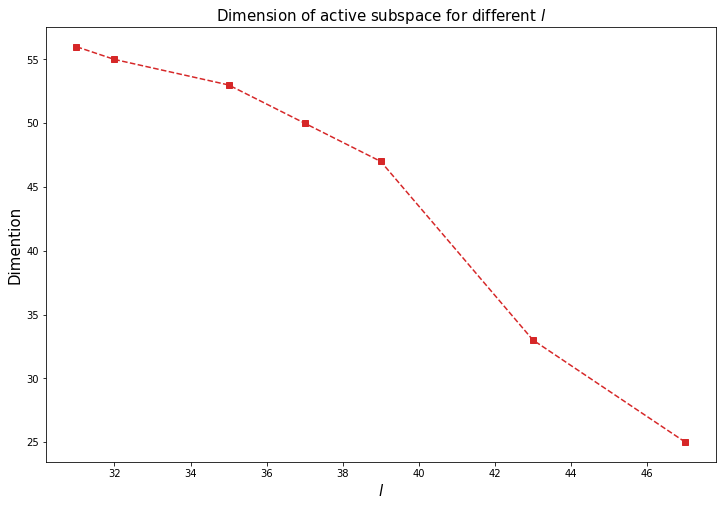

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(lss,actives,'C3s--')
plt.title('Dimension of active subspace for different $l$', fontsize=15)
plt.xlabel("$l$", fontsize=15)
plt.ylabel("Dimention", fontsize=15)

(-0.0, 80.0)

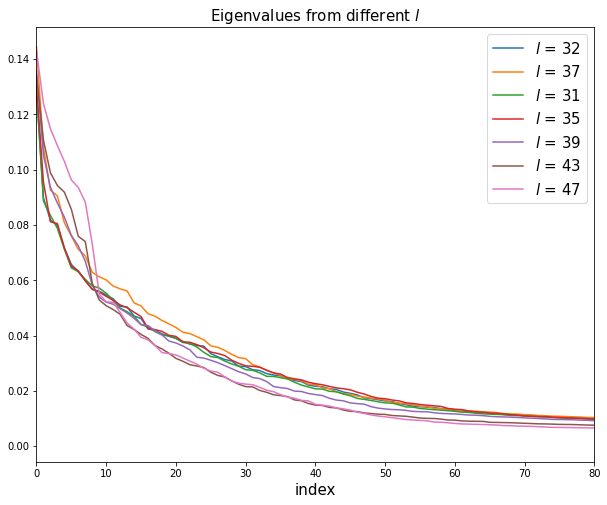

In [ ]:
plt.figure(figsize=(10,8))
for i in range(7):
  for l in sigmass[i].keys():
    if len(sigmass[i].get(l)):
      plt.plot(sigmass[i].get(l), label=f'$l$ = {l}')
plt.legend(fontsize=15)
plt.title("Eigenvalues from different $l$", fontsize=15)
plt.xlabel('index', fontsize=15)
plt.xlim((-0.0,80.))

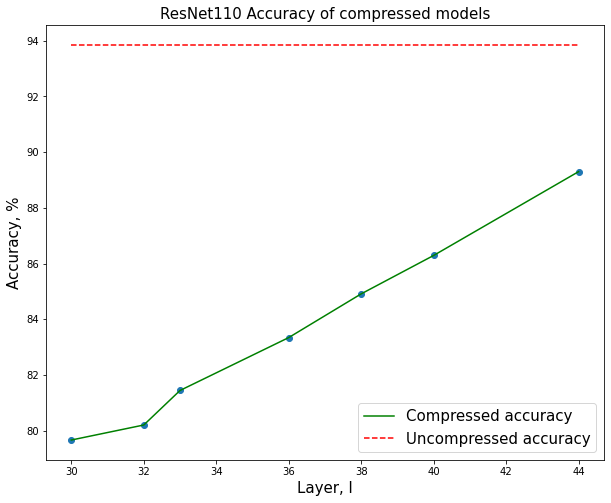

In [282]:
plt.figure(figsize=(10,8))
plt.plot(idxes,zero_results, 'g',label='Сompressed accuracy')
plt.hlines(93.86, 30, 44, linestyles='--', color='r', label='Uncompressed accuracy')
plt.scatter(idxes,zero_results)
plt.title("ResNet110 Accuracy of compressed models", fontsize=15)
plt.xlabel('Layer, l', fontsize=15)
plt.ylabel('Accuracy, %', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
#plt.xlim((-0.0,80.))

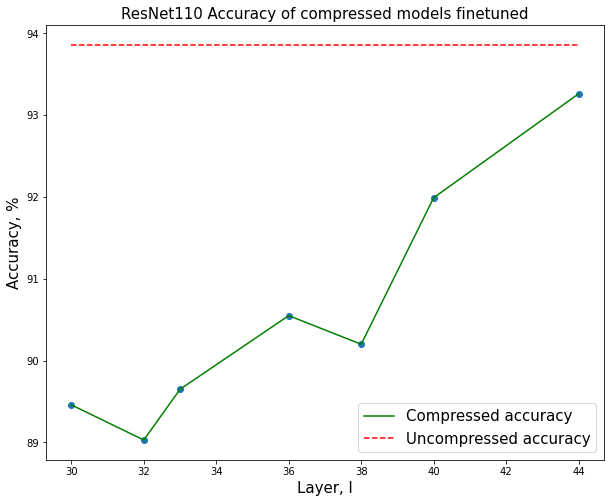

In [283]:
plt.figure(figsize=(10,8))
plt.plot(idxes,tune_results, 'g',label='Сompressed accuracy')
plt.hlines(93.86, 30, 44, linestyles='--', color='r', label='Uncompressed accuracy')
plt.scatter(idxes,tune_results)
plt.title("ResNet110 Accuracy of compressed models finetuned", fontsize=15)
plt.xlabel('Layer, l', fontsize=15)
plt.ylabel('Accuracy, %', fontsize=15)
plt.legend(loc='lower right', fontsize=15)
#plt.xlim((-0.0,80.))

Text(0, 0.5, 'Compression rate, %')

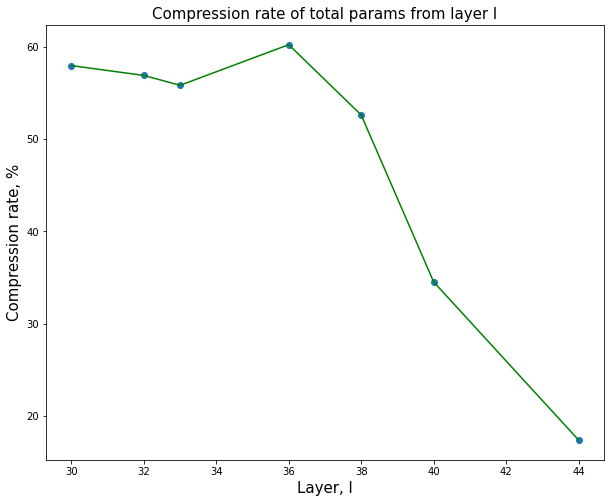

In [274]:
plt.figure(figsize=(10,8))
plt.plot(idxes,compression_rates, 'g')
plt.scatter(idxes,compression_rates)
plt.title("Compression rate of total params from layer l", fontsize=15)
plt.xlabel('Layer, l', fontsize=15)
plt.ylabel('Compression rate, %', fontsize=15)

Text(0, 0.5, 'Compression rate, %')

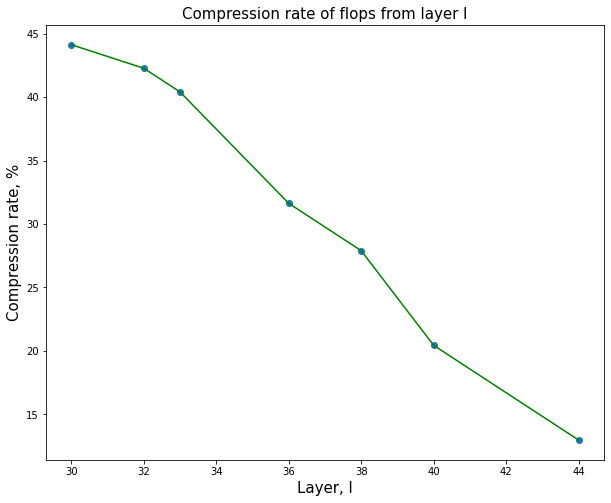

In [275]:
plt.figure(figsize=(10,8))
plt.plot(idxes,flops_compression, 'g')
plt.scatter(idxes,flops_compression)
plt.title("Compression rate of flops from layer l", fontsize=15)
plt.xlabel('Layer, l', fontsize=15)
plt.ylabel('Compression rate, %', fontsize=15)